In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim


import torchvision
from torchvision import transforms, datasets
from torchsummary import summary #just for debugging
from torch.utils.tensorboard import SummaryWriter

import Sample_Creator

In [2]:
def Dataloader(traindir, testdir, image_size, batch_size):
    
    
    train_transform = transforms.Compose([transforms.Resize(image_size),
                                          transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0),
                                          transforms.RandomVerticalFlip(0.5),
                                          transforms.ToTensor(),
                                          ])
    
    test_transform = transforms.Compose([transforms.Resize(image_size),
                                         transforms.ToTensor(),
                                         ])
    
    
    train_data = datasets.ImageFolder(traindir, transform = train_transform)
    test_data = datasets.ImageFolder(testdir, transform = test_transform)
    
    
    classes = train_data.classes
    
    
    trainloader = torch.utils.data.DataLoader(train_data, shuffle = True, batch_size = batch_size)
    testloader = torch.utils.data.DataLoader(test_data, shuffle = True, batch_size = len(test_data))
    
    return trainloader, testloader, classes

In [3]:
def setup_data():
    TRAIN_DIR = "./Data/seg_train"
    TEST_DIR = "./Data/seg_test"
    
    BATCH_SIZE = 32
    IMAGE_SIZE = (64,64) # resize the images
    SEED = 128
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    train_ds, test_ds, class_names = Dataloader(traindir=TRAIN_DIR, testdir=TEST_DIR, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE)
    
    return train_ds, test_ds, class_names

In [4]:
train_ds, test_ds, class_names = setup_data()

In [5]:
def load_one_sample(filename, create_hex = False):
    
    sample_intel = np.load(filename)
    print(f" sample_data shape: {sample_intel.shape}")
    
    if create_hex:
        Sample_Creator.convert(filename, from_dir = True)
        
    return sample_intel

In [6]:
def create_one_sample(dataset, index_of_sample = 0, save_numpy = False, create_hex = False):
    """
    create one sample from a dataset
    the sample gets normalized as in the dataloader defined in intelnet.py
    then a hex file from that sample is created
    """
    
    assert index_of_sample >= 0, f"index_of_samples needs to be at least 0"
    
    sample = next(iter(dataset))
        
    sample_pic = sample[0][index_of_sample]
    sample_label = sample[1][index_of_sample]
    
    sample_original = sample_pic.numpy().copy()
    
    print(f"Sample is form class: {class_names[sample_label]}")
    
    sample_pic = Sample_Creator.ai8x_normalize(sample_pic).numpy()
    sample_pic = sample_pic.astype(np.int64)
    
    if save_numpy:
        np.save("sample_created", sample_pic, allow_pickle=False, fix_imports=False)
        
    if create_hex:
        Sample_Creator.convert(sample_pic, from_dir = False)
        
    return sample_original, sample_pic, class_names[sample_label]
        

In [7]:
sample_intel = load_one_sample("sample_intel.npy", False)

 sample_data shape: (3, 64, 64)


In [28]:
sample_original, sample_pic, sample_label = create_one_sample(dataset = test_ds, index_of_sample = 5, save_numpy = False, create_hex = True)

Sample is form class: street
FINISH


In [20]:
for _ in range(20):
    sample_original, sample_pic, sample_label = create_one_sample(dataset = test_ds, index_of_sample = 5, save_numpy = False, create_hex = True)
    if sample_label == "street":
        break

Sample is form class: forest
FINISH
Sample is form class: street
FINISH


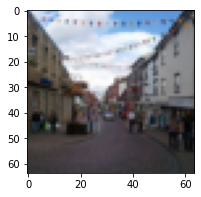

street


In [21]:
class_dict = {"buildings":0,"forest":1,"glacier":2,"mountain":3,"sea":4,"street":5}

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.transpose((1, 2, 0))
    if inp.dtype == np.int64:
        inp += 128
    plt.figure(figsize = (3,3))
    plt.imshow(inp, aspect='auto')
    if title is not None:
        plt.title(title)
    plt.savefig("Sample_street.png", pad_inches=0, dpi = 600)
    plt.pause(0.001)  # pause a bit so that plots are updated



imshow(sample_original.copy())
#imshow(sample_intel.copy())
#imshow(sample_pic.copy())
print(sample_label)
#print(list(class_dict.keys())[list(class_dict.values()).index(sample_label)])